<a href="https://colab.research.google.com/github/Sciform/sciform-hwz-ai-in-controlling/blob/main/lecture_1/1_3_customer_lifetime_value_student_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install chart_studio

In [3]:
from datetime import datetime, timedelta,date
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [5]:
# pyoff.init_notebook_mode()

In [6]:
!wget https://raw.githubusercontent.com/sciform/sciform-hwz-ai-in-controlling/main/data/online_retail.csv

--2024-06-10 20:10:12--  https://raw.githubusercontent.com/sciform/sciform-hwz-ai-in-controlling/main/data/online_retail.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45580638 (43M) [text/plain]
Saving to: ‘online_retail.csv’

online_retail.csv   100%[===================>]  43.47M   182MB/s    in 0.2s    

2024-06-10 20:10:12 (182 MB/s) - ‘online_retail.csv’ saved [45580638/45580638]



In [7]:
import io
tx_data = pd.read_csv('online_retail.csv', encoding = "ISO-8859-1")

In [8]:
tx_data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [9]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

In [10]:
tx_data['InvoiceDate'].describe()

count                           541909
mean     2011-07-04 13:34:57.156386048
min                2010-12-01 08:26:00
25%                2011-03-28 11:34:00
50%                2011-07-19 17:17:00
75%                2011-10-19 11:27:00
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [11]:
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

In [12]:
date(2007, 12, 5)

datetime.date(2007, 12, 5)

# Create time window for CLV

We use 6 month here. Depending on your industry or strategy you might want to choose a different length for the time frame.

In [13]:
# collect invoice date form 1.3.2011 - 31.5.2011
tx_3m = tx_uk[(tx_uk.InvoiceDate < pd.to_datetime(date(2011,6,1))) & (tx_uk.InvoiceDate >= pd.to_datetime(date(2011,3,1)))].reset_index(drop=True)
# collect invoice date form 1.6.2011 - 1.12.2011 for our time window
tx_6m = tx_uk[(tx_uk.InvoiceDate >= pd.to_datetime(date(2011,6,1))) & (tx_uk.InvoiceDate < pd.to_datetime(date(2011,12,1)))].reset_index(drop=True)

## Create RFM score for every customer with data of the first 3 month

In [15]:
tx_3m['InvoiceDate'].describe()

count                            95193
mean     2011-04-15 21:47:37.643313920
min                2011-03-01 08:30:00
25%                2011-03-24 09:50:00
50%                2011-04-15 10:37:00
75%                2011-05-10 11:44:00
max                2011-05-31 15:53:00
Name: InvoiceDate, dtype: object

In [16]:
tx_user = pd.DataFrame(tx_3m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

### Recency (data of first 3 month)




In [17]:
tx_max_purchase = tx_3m.groupby('CustomerID').InvoiceDate.max().reset_index()

In [18]:
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [19]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [20]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [21]:
tx_user.head()

,CustomerID,Recency
0,14620.0,12
1,14740.0,4
2,13880.0,25
3,16462.0,91
4,17068.0,11


In [22]:
tx_user.Recency.describe()

count    1840.000000
mean       35.145652
std        26.231112
min         0.000000
25%        12.000000
50%        26.000000
75%        56.000000
max        91.000000
Name: Recency, dtype: float64

In [23]:
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [24]:
import warnings
warnings.filterwarnings("ignore")

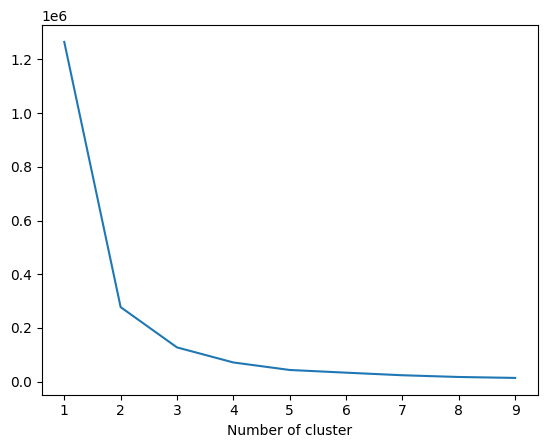

In [25]:
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [26]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [27]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,608.0,8.312500,4.404323,0.0,5.0,8.0,12.0,16.0
1,349.0,76.885387,8.373023,64.0,70.0,76.0,84.0,91.0
2,439.0,50.020501,7.377743,39.0,43.0,49.0,56.0,63.0
3,444.0,24.373874,4.959870,17.0,20.0,23.0,27.0,35.0


In [28]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [29]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

### Frequency (data of first 3 month)

In [30]:
tx_frequency = tx_3m.groupby('CustomerID').InvoiceDate.count().reset_index()

In [31]:
tx_frequency.columns = ['CustomerID','Frequency']

In [32]:
tx_frequency.head()

,CustomerID,Frequency
0,12747.0,35
1,12748.0,582
2,12749.0,54
3,12821.0,6
4,12823.0,1


In [33]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [34]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,14620.0,12,3,30
1,14740.0,4,3,89
2,17068.0,11,3,76
3,12971.0,4,3,73
4,15194.0,6,3,64


In [35]:
tx_user.Frequency.describe()

count    1840.000000
mean       38.958152
std        60.968929
min         1.000000
25%        12.000000
50%        23.000000
75%        47.000000
max      1364.000000
Name: Frequency, dtype: float64

In [36]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

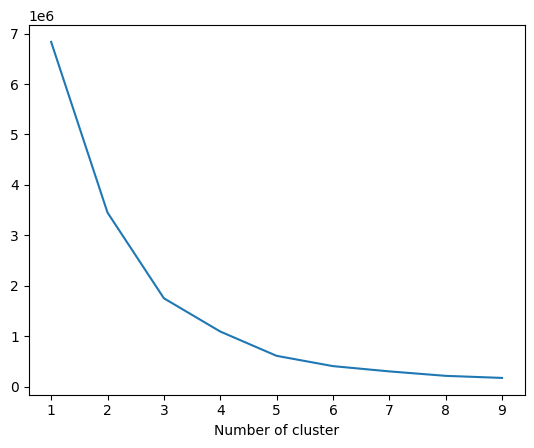

In [37]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [38]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [39]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1605.0,24.218069,17.761893,1.0,10.0,20.0,36.0,70.0
1,223.0,116.560538,43.816927,71.0,83.5,104.0,131.5,285.0
2,11.0,496.000000,125.912668,331.0,422.5,452.0,570.0,730.0
3,1.0,1364.000000,NaN,1364.0,1364.0,1364.0,1364.0,1364.0


In [40]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

### Revenue (data of first 3 month)

In [ ]:
tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']

In [ ]:
tx_revenue = tx_3m.groupby('CustomerID').Revenue.sum().reset_index()

In [ ]:
tx_revenue.head()

,CustomerID,Revenue
0,12747.0,1082.09
1,12748.0,4336.73
2,12749.0,782.10
3,12821.0,92.72
4,12823.0,459.00


In [ ]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

In [ ]:
tx_user.Revenue.describe()

count     1840.000000
mean       738.715017
std       1640.430156
min      -1462.500000
25%        210.237500
50%        369.825000
75%        749.490000
max      35085.480000
Name: Revenue, dtype: float64

In [ ]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value/Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

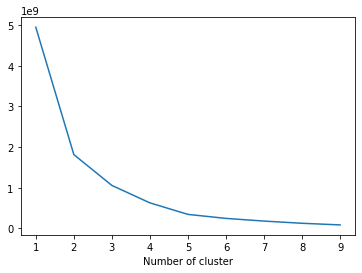

In [ ]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [ ]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [ ]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1756.0,504.760245,444.567580,-1462.50,204.3075,349.590,666.8325,2131.72
1,72.0,3760.423486,1538.877714,2159.16,2685.1875,3141.610,4222.5050,7969.99
2,10.0,14092.686000,2855.109881,10348.13,11268.3675,15124.345,16124.8250,17700.64
3,2.0,30599.645000,6343.928696,26113.81,28356.7275,30599.645,32842.5625,35085.48


### Overall Segmentation for first 3 month data

In [ ]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,12,3,30,0,393.28,0
1,15194.0,6,3,64,0,1439.02,0
2,18044.0,5,3,57,0,808.96,0
3,18075.0,12,3,35,0,638.12,0
4,15241.0,0,3,64,0,947.55,0


In [ ]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [ ]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,77.014925,18.432836,295.824239
1,50.887828,24.522673,367.334177
2,26.590476,31.028571,500.973095
3,10.243902,36.652439,633.871402
4,8.109375,103.835938,1983.985086
5,6.482759,138.965517,4326.155172
6,7.357143,322.071429,12177.627143
7,3.000000,779.333333,11350.896667


In [ ]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    335
1    419
2    420
3    492
4    128
5     29
6     14
7      3
Name: Recency, dtype: int64

Create 3 segments "Low-value", "mid-value", "high-value" from the 8 overall score segments (to simplify the classification).

In [ ]:
# create 3 segments
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value'
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value'

In [ ]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Dataframe with 3 segments


In [ ]:
 tx_user.head(-1)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value
...,...,...,...,...,...,...,...,...,...
1834,13798.0,4,3,122,1,11105.20,2,6,High-Value
1835,17511.0,14,3,199,1,17307.53,2,6,High-Value
1836,16684.0,13,3,73,1,15263.96,2,6,High-Value
1837,15311.0,4,3,522,2,16309.61,2,7,High-Value


## Compute CLV (here = revenue) with 6 month of data

In [ ]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom


Compute revenue in the 6 month time window for every customer

In [ ]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom,22.50
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom,16.95
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom,66.40
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom,32.70
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom,51.00


In [ ]:
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.head(5)

,CustomerID,Revenue
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98


Compute CLV - as in our case CLV = revenue, we simply rename the column "Revenue" to "m6_CLV"

In [ ]:
tx_user_6m.columns = ['CustomerID','m6_CLV']
tx_user_6m.head(5)

,CustomerID,m6_CLV
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98


In [ ]:
plot_data = [
    go.Histogram(
        x=tx_user_6m.query('m6_CLV < 10000')['m6_CLV']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Create the data set for the classification

The data set consists of input features X (RFM score and segments) as well as the corresponding labels Y - the CLV cluster ID

Merge the RFM and segment feature dataframe computed from the first 3 month with the CLV computed from the 6 month time window for every customer.

In [ ]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left')

In [ ]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_CLV
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,NaN
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04


In [ ]:
tx_merge = tx_merge.fillna(0)

Compute the mean CLV for every customer segment.

In [ ]:
tx_merge.groupby('Segment')['m6_CLV'].mean()

Segment
High-Value    17968.362609
Low-Value       703.559983
Mid-Value      1718.212598
Name: m6_CLV, dtype: float64

In [ ]:
tx_graph = tx_merge.query("m6_CLV < 30000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_CLV'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_CLV'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_CLV'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m CLV"},
        xaxis= {'title': "RFM Score"},
        title='CLV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
# we can observe a positive correlation between a high RFM score and a high CLV.

# remove outliers
tx_merge = tx_merge[tx_merge['m6_CLV']<tx_merge['m6_CLV'].quantile(0.99)]

Compute the target CLV cluster for every customer by clustering all CLV values in 3 clusters.

In [ ]:
# we cluster all CLV (= revenue) values for all customers

kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_CLV']])
tx_merge['CLVCluster'] = kmeans.predict(tx_merge[['m6_CLV']])

In [ ]:
tx_merge = order_cluster('CLVCluster', 'm6_CLV', tx_merge, True)

In [ ]:
tx_merge.groupby('CLVCluster')['m6_CLV'].describe()

,count,mean,std,min,25%,50%,75%,max
CLVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


In [ ]:
tx_data_set = tx_merge.copy()

In [ ]:
tx_data_set.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_CLV,CLVCluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0
1,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54,0
2,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75,0
3,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04,0
4,15660.0,4,3,34,0,484.62,0,3,Mid-Value,858.09,0


In [ ]:
tx_data_set.groupby('CLVCluster')['m6_CLV'].describe()

,count,mean,std,min,25%,50%,75%,max
CLVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


In [ ]:
tx_data_set.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_CLV,CLVCluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0
1,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54,0
2,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75,0
3,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04,0
4,15660.0,4,3,34,0,484.62,0,3,Mid-Value,858.09,0


# Classification for CLV


## Feature engineering  
We need to encode categorical values numerically. The get_dummies() method does this automatically. It splits the "segment" column into 3 columns "Segment_High-Value", "Segment_Mid-Value", "Segment_Low-Value".
The value of segment column, the customer belongs to, is equal to 1, otherwise it is equal to 0.

In [ ]:
tx_enc_data_set = pd.get_dummies(tx_data_set)

In [ ]:
tx_enc_data_set.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_CLV,CLVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,14620.0,12,3,30,0,393.28,0,3,0.00,0,0,0,1
1,18044.0,5,3,57,0,808.96,0,3,991.54,0,0,0,1
2,18075.0,12,3,35,0,638.12,0,3,1322.75,0,0,0,1
3,15241.0,0,3,64,0,947.55,0,3,791.04,0,0,0,1
4,15660.0,4,3,34,0,484.62,0,3,858.09,0,0,0,1


In [ ]:
cluster_size_in_ptc = tx_enc_data_set.groupby('CLVCluster').CustomerID.count()/tx_enc_data_set.CustomerID.count()
print(cluster_size_in_ptc)

CLVCluster
0    0.765513
1    0.203734
2    0.030752
Name: CustomerID, dtype: float64


### Feature Importance
It is very rare that all the variables in the dataset are useful to build a model. Adding redundant variables reduces the generalization capability of the model and may also reduce the overall accuracy of a classifier.

Computing a correlation matrix between features and the target "CLVCLuster"

In [ ]:
# evaluate correlations
corr_matrix = tx_enc_data_set.corr()
corr_matrix['CLVCluster'].sort_values(ascending=False)

CLVCluster            1.000000
m6_CLV                0.845933
Revenue               0.600491
RevenueCluster        0.467191
OverallScore          0.373114
FrequencyCluster      0.366366
Frequency             0.359601
Segment_High-Value    0.352387
RecencyCluster        0.236899
Segment_Mid-Value     0.168473
CustomerID           -0.028401
Recency              -0.237249
Segment_Low-Value    -0.266008
Name: CLVCluster, dtype: float64

## Create input feature X and label data y from the encoded data set

For the input features X we just have to drop the labels 'CLVCluster' and the redundant 'm6_CLV' column. The label is simply the 'CLVCluster' columns as we would like to classify every customer into one of these 3 CLV groups.

In [ ]:
# create input data / features X and corresponding labels y

X = tx_enc_data_set.drop(['CLVCluster','m6_CLV'],axis=1)
y = tx_enc_data_set['CLVCluster']

In [ ]:
# input data or feature - for every customer we have all RFM scores as well as segments as features
X.head(10)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,14620.0,12,3,30,0,393.28,0,3,0,0,1
1,18044.0,5,3,57,0,808.96,0,3,0,0,1
2,18075.0,12,3,35,0,638.12,0,3,0,0,1
3,15241.0,0,3,64,0,947.55,0,3,0,0,1
4,15660.0,4,3,34,0,484.62,0,3,0,0,1
5,14676.0,15,3,18,0,1144.77,0,3,0,0,1
6,14560.0,3,3,12,0,562.28,0,3,0,0,1
7,16389.0,13,3,16,0,670.17,0,3,0,0,1
8,17961.0,3,3,68,0,263.96,0,3,0,0,1
9,13094.0,13,3,9,0,481.44,0,3,0,0,1


In [ ]:
# labels - for every customer we have the CLV cluster id 0,1, or 2
y.head(-1)

0       0
1       0
2       0
3       0
4       0
       ..
1815    2
1816    2
1817    2
1818    2
1819    2
Name: CLVCluster, Length: 1820, dtype: int64

## Create training and test data pairs (X_train, y_train) and (X_test, y_test)

We use 95 % of our data for training and 5 % for testing. Check what happens if you use only 80 % for training and 20 % for testing.

In [ ]:
# split input data X into train X_train and test X_test data sets
# split labels y into train  y_train and test y_test data sets
# train size = 95 % and test size = 5 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

## Perform training of the classification model with XGBoost algorithm.

In [ ]:
# perform training of the classification model https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.training

ltv_xgb_model = xgb.XGBClassifier(
    max_depth=5, # depth of the decision trees
    learning_rate=0.1, # factor for Stochastic Gradient Descent to step towards the local minimum
    verbosity=1,
    objective= 'multi:softprob', # objective function / costfunction
    n_jobs=-1).fit(X_train, y_train)

In [ ]:
print('Accuracy of XGB classifier on training set: {:.2f}'.format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.90
Accuracy of XGB classifier on test set: 0.87


## Compute prediction for test set X_test

In [ ]:
# compute prediction y_pred for input test set
y_pred = ltv_xgb_model.predict(X_test)

## Evaluate the trained model by comparing the prediction y_pred with the actual labels y_test and compute accuracy metrics.

In [ ]:
# print most important metrics
# https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94        70
           1       0.82      0.50      0.62        18
           2       0.50      0.50      0.50         4

    accuracy                           0.87        92
   macro avg       0.74      0.66      0.69        92
weighted avg       0.86      0.87      0.86        92


# TODO

Select the 5th customer in the test set and compute the prediction of the CLV Cluster.

Create your one customer dataframe and compute the prediction of the CLV cluster.


In [ ]:
# 5ht customer
X_test_5th_customer = X_test.iloc[4:5]